In [1]:
from collections import OrderedDict
from functools import partial
from time import time
from sklearn.cluster import KMeans
from sklearn import metrics

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.decomposition import PCA, KernelPCA
# Next line to silence pyflakes. This import is needed.
from tensorflow.keras.models import load_model
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Add 3d scatter plot
# Set-up manifold methods

def project_data(X, n_components, frequency_domin, num_clusters):
    LLE = partial(manifold.LocallyLinearEmbedding,
                  n_neighbors, n_components, eigen_solver='auto')
    clusters = OrderedDict()
    methods = OrderedDict()
    projected_data = OrderedDict()
    methods['PCA'] = PCA(n_components=n_components)
    methods['Kernel PCA Sigmoid'] = KernelPCA(n_components=n_components, kernel='sigmoid')
    # methods['Kernel PCA poly'] = KernelPCA(n_components=n_components, kernel='poly')
    # methods['Kernel PCA rbf'] = KernelPCA(n_components=n_components, kernel='rbf')
    # methods['Kernel PCA cosine'] = KernelPCA(n_components=n_components, kernel='cosine')
    methods['LLE'] = LLE(method='standard')
    # methods['LTSA'] = LLE(method='ltsa')
    # methods['Hessian LLE'] = LLE(method='hessian')
    # methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
    # methods['SE'] = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                     random_state=0)
    methods['Autoencoder_3'] = load_model("encoder_3")
    methods['Autoencoder_200'] = load_model("encoder_200")

    for i, (label, method) in enumerate(methods.items()):
        if label not in ['Autoencoder_200', 'Autoencoder_3']:
            Y = method.fit_transform(X)
        else:
            Y = method.predict(X)
        clusters[label] = KMeans(n_clusters=num_clusters, random_state=0).fit(Y)
        projected_data[label] = Y
    return projected_data, clusters

In [3]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

In [4]:
def clustering_scores(rojected_data, clusters, num_clusters = 4, method = "Autoencoder_200"):
    cluster_labels = clusters[method].labels_
    centroids = clusters[method].cluster_centers_
    u_labels = np.unique(clusters[method].labels_)
    silhouette_avg = silhouette_score(projected_data[method], cluster_labels)
    sample_silhouette_values = silhouette_samples(projected_data[method], cluster_labels)

    true_centroids = []
    for key, label in labels_dict.items():
        class_centriod = projected_data[method][np.where(np.array(true_labels) == key)].mean(axis=0)
        true_centroids.append(class_centriod)
    true_centroids_array = np.array(true_centroids)


    predicted_labels = np.zeros(np.array(true_labels).shape)
    predicted_centroids = np.zeros(true_centroids_array.shape)
    
    row = OrderedDict()
    row["Method"] = method
    for i in u_labels:
        # Calculate predicted cluster centriod
        class_centriod = projected_data[method][np.where(cluster_labels == i)].mean(axis=0)
        # Get the true centriod by calculaing the closest centriod to the predicted one
        matched_true_centriod_index = closest_node(class_centriod, true_centroids)
        matched_true_centriod = true_centroids[matched_true_centriod_index]
        
        predicted_centroids[matched_true_centriod_index,] = class_centriod
        
        # Get ture labels indices
        true_indices = np.where(np.array(true_labels)==matched_true_centriod_index)
        # Get predicted labels indices
        predicted_indices = np.where(cluster_labels == i)
        predicted_labels[predicted_indices] = matched_true_centriod_index
        
        compare_indices = np.isin(predicted_indices, true_indices)
        TP, FP = np.count_nonzero(compare_indices), np.count_nonzero(compare_indices==0)
        compare_indices_true_in_predicted = np.count_nonzero(np.isin(true_indices, predicted_indices))
        FN = np.count_nonzero(np.isin(true_indices, predicted_indices)==0)
        
        
        true_centroids.pop(matched_true_centriod_index)
        true_centroids.insert(matched_true_centriod_index,np.ones(true_centroids[0].shape)*np.inf)

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        row[f"{labels_dict[matched_true_centriod_index]} Average Silhouette"] = ith_cluster_silhouette_values.mean()
        

    row["Average Silhouette"] = silhouette_avg
    row["Adjusted Rand Score"] = metrics.adjusted_rand_score(np.array(true_labels), predicted_labels)
    row["Adjusted Mutual Info Score"] = metrics.adjusted_mutual_info_score(np.array(true_labels), predicted_labels)
    row["Homogeneity Score"] = metrics.homogeneity_score(np.array(true_labels), predicted_labels)
    row["Completeness Score"] = metrics.completeness_score(np.array(true_labels), predicted_labels)
    row["Fowlkes Mallows Score"] = metrics.fowlkes_mallows_score(np.array(true_labels), predicted_labels)
    
    return row, predicted_labels, projected_data, predicted_centroids, true_centroids_array

# Read data

In [5]:
sample_n = 85
multiplyer = 1
image_size = (64, 64)
frequency_domin = False
normlized = False
num_clusters = 3
import numpy as np
X = np.load("X.npy")
true_labels = [0 for _ in range(sample_n)] + [1 for _ in range(sample_n)] + [2 for _ in range(sample_n)] + [3 for _ in range(multiplyer * sample_n)]


unique_color = set(true_labels)
colors_dict = {0: 'r', 1: 'g', 2: 'b', 3: 'black'}
labels_dict = {0: 'N.Y.C', 1: 'Paris', 2: 'Barcelona', 3: 'Germany'}
color = [colors_dict[key] for key in true_labels]
points_label = [labels_dict[key] for key in true_labels]

In [6]:
n_neighbors = 10
n_components = 2

In [7]:
projected_data, clusters = project_data(X, n_components, frequency_domin, num_clusters)

W0725 18:18:14.757489 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.
W0725 18:18:14.810301 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.


In [8]:
def plot(projected_data,
         method,
         true_lables,
         predicted_lables,
         predicted_class_centriods,
         true_centroids_array,
         s = 10,
         s_ratio = 3, counter = 0):
    
    ax = plt.subplot(8,2,1 + counter * 2)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    handles, labels = ax.get_legend_handles_labels()
    ax.set_title(f"{method} GT")
    for i in range(4):  
        plt.scatter(projected_data[method][np.array(true_labels) == i][:,0] ,
                    projected_data[method][np.array(true_labels) == i][:,1] ,
                    label = labels_dict[i],
                    color = colors_dict[i],
                    zorder=1)
        plt.scatter(true_centroids_array[i,0],
                    true_centroids_array[i,1],
                    s = s,
                    zorder=3,
                    color = colors_dict[i],
                    linewidth =s/s_ratio,
                    label = f"{labels_dict[i]} centriod")
    
    ax = plt.subplot(8,2,2 + counter * 2)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    handles, labels = ax.get_legend_handles_labels()
    ax.set_title(f"{method} P")
    for i in range(4):
        plt.scatter(projected_data[method][predicted_lables == i][:,0],
                    projected_data[method][predicted_lables == i][:,1],
                    label = f"{labels_dict[i]} centriod",
                    color = colors_dict[i], zorder=1)
        plt.scatter(predicted_class_centriods[i, 0],
                    predicted_class_centriods[i, 1],
                    s = s,
                    zorder=3,
                    linewidth =s/s_ratio,
                    label = f"{labels_dict[i]} centriod",
                    color = colors_dict[i])

    counter = counter + 1
    
    return counter

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 36}
plt.rc('font', **font)

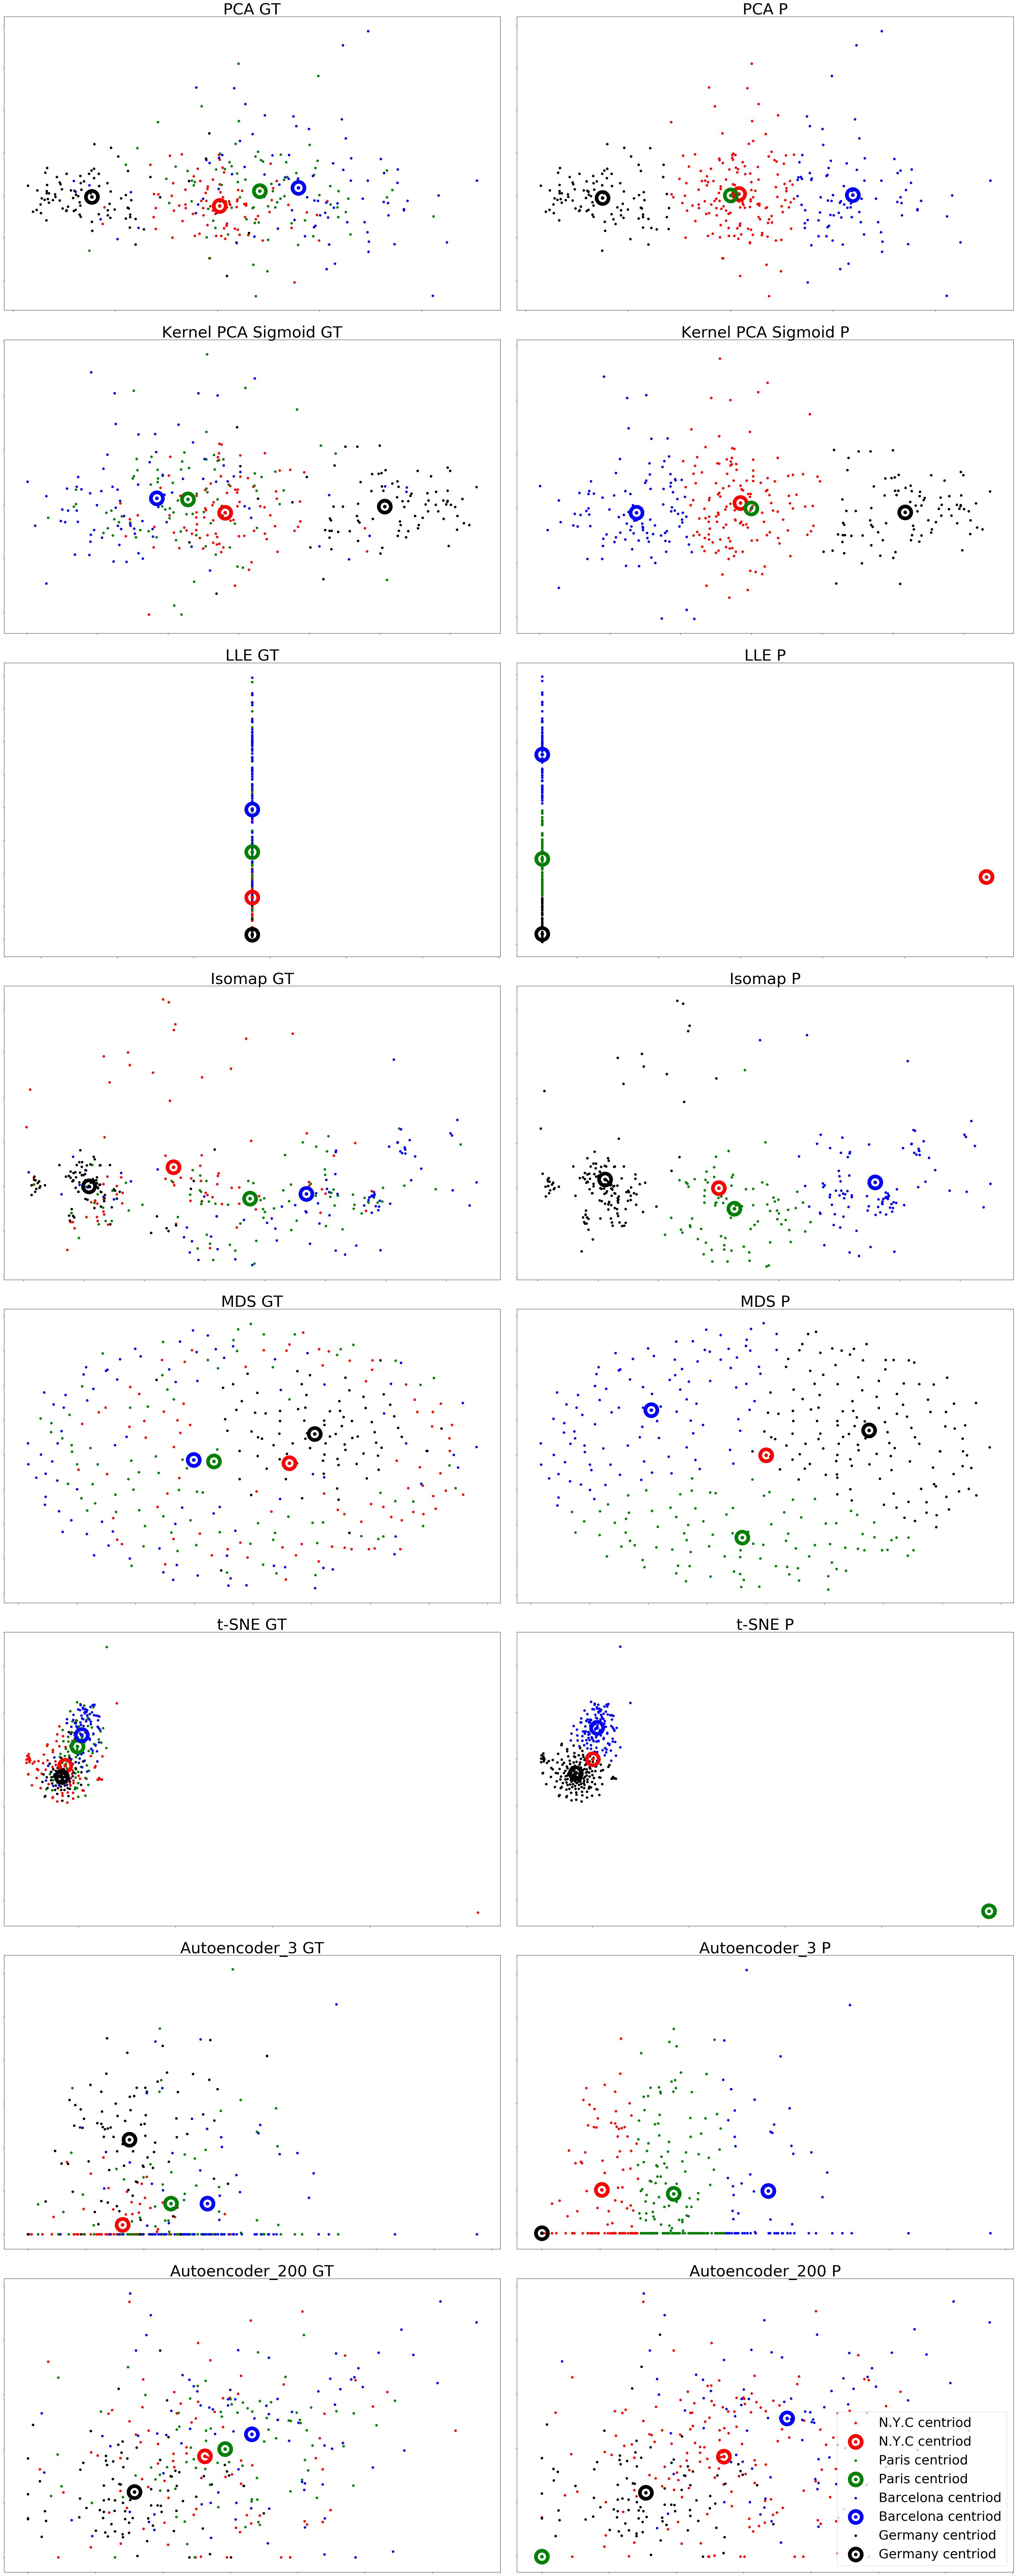

In [10]:
row_list = []
num_clusters = 4
counter = 0
centriod_s = 100
plt.figure(figsize= (40,100))
for method, function in clusters.items():
    row, predicted_labels, projected_data, predicted_centroids, true_centroids_array = clustering_scores(projected_data, clusters, num_clusters = num_clusters, method = method)
    counter = plot(projected_data, method, true_labels,predicted_labels, predicted_centroids, true_centroids_array, s = centriod_s, counter = counter)
    row_list.append(row)
plt.legend()
plt.tight_layout()
plt.savefig("clustering evaluation 4.png")

In [11]:
df_4_clusters = pd.DataFrame(row_list)
df_4_clusters.to_csv('df_4_clusters.csv', index=False , sep="\t")
df_4_clusters

,Method,N.Y.C Average Silhouette,Barcelona Average Silhouette,Germany Average Silhouette,Average Silhouette,Adjusted Rand Score,Adjusted Mutual Info Score,Homogeneity Score,Completeness Score,Fowlkes Mallows Score,Paris Average Silhouette
0,PCA,0.419732,0.353272,0.606143,0.454773,0.338386,0.370486,0.331953,0.431038,0.539387,NaN
1,Kernel PCA Sigmoid,0.350453,0.376778,0.565198,0.415582,0.344747,0.380051,0.342044,0.439075,0.540728,NaN
2,LLE,NaN,0.622998,0.815018,0.692125,0.194642,0.247894,0.219625,0.299691,0.449799,0.503564
3,Isomap,NaN,0.470226,0.554952,0.505139,0.192061,0.208254,0.189656,0.245516,0.433082,0.459736
4,MDS,NaN,0.374271,0.397665,0.392038,0.127945,0.127654,0.119478,0.152393,0.382442,0.402971
5,t-SNE,NaN,0.544364,0.529359,0.533848,0.179009,0.217307,0.167769,0.335731,0.484020,0.000000
6,Autoencoder_3,0.415418,0.355589,NaN,0.383666,0.054058,0.089636,0.083869,0.113260,0.345803,0.376306
7,Autoencoder_200,0.152959,0.145387,0.451831,0.234597,0.326480,0.359062,0.320369,0.420704,0.533883,NaN


W0725 18:18:22.242115 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.
W0725 18:18:22.293241 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.
W0725 18:18:25.593362 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.
W0725 18:18:25.644050 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.
W0725 18:18:28.972644 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.
W0725 18:18:29.023202 140044221167296 load.py:128] No training configuration found in save file, so the model was *not* compiled. Compile it manually.
W0725 18:18:32.429485 140044221167296 load.py:128] No training configuration found in save fil

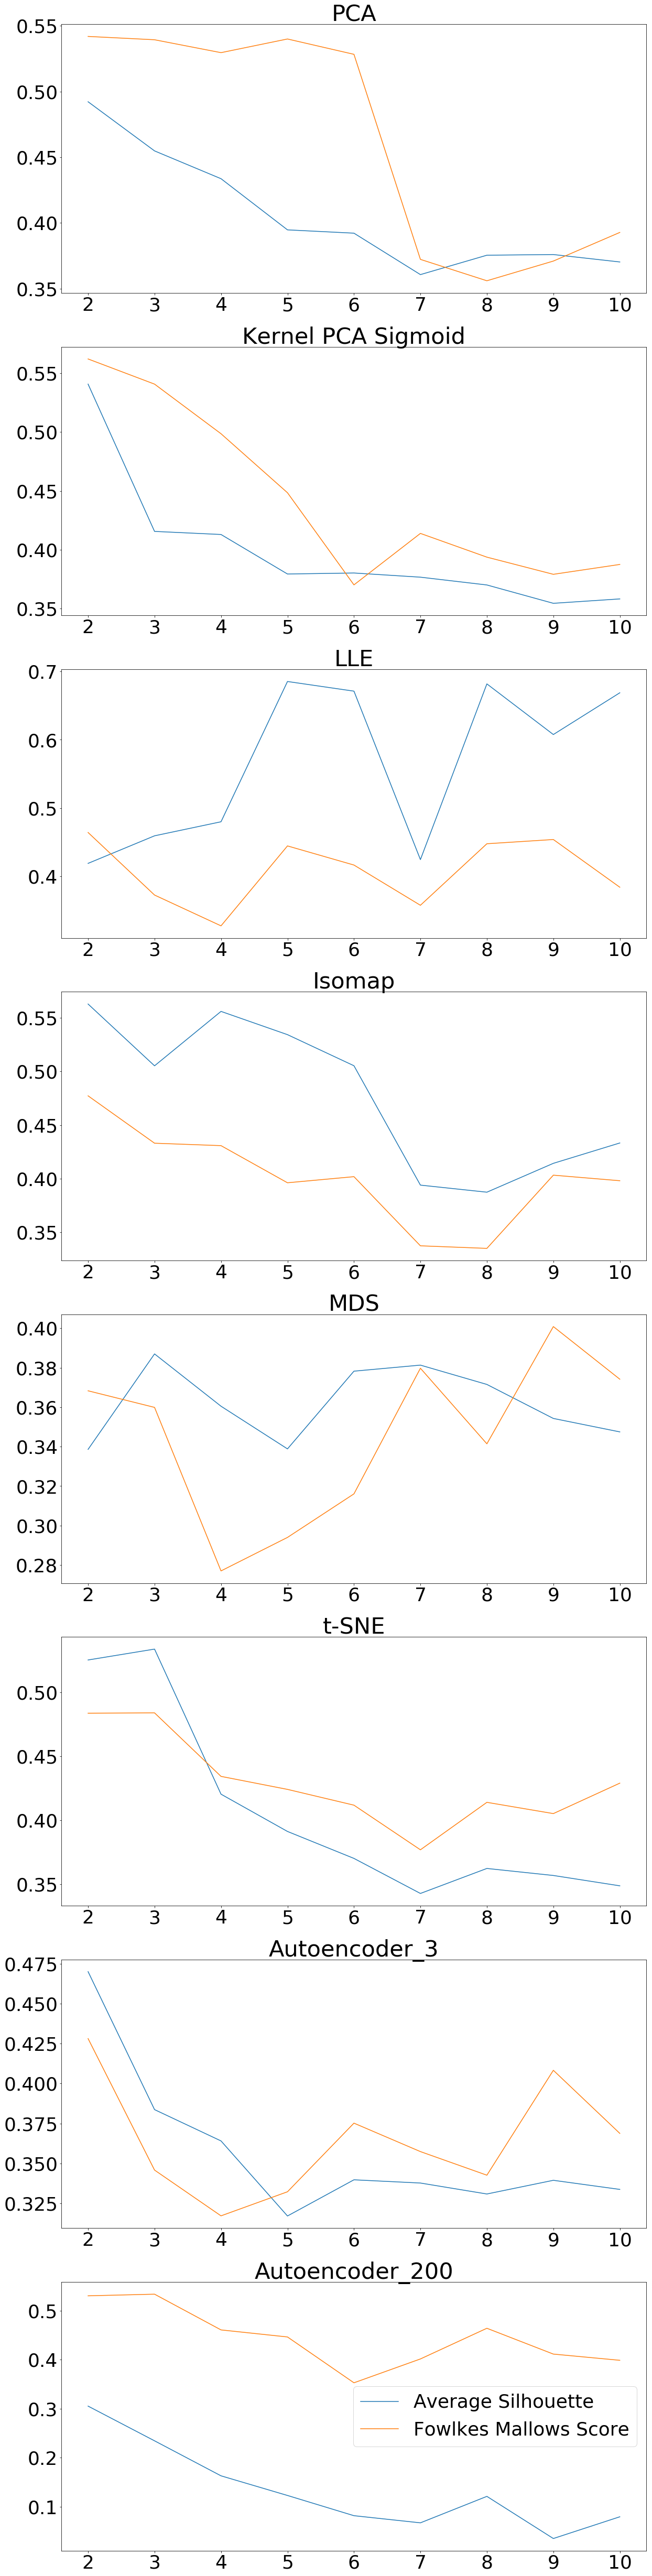

In [12]:
row_list = []
num_clusters = [2,3,4,5,6,7,8,9,10]
plt.figure(figsize= (20,100))
for i, (method, function) in enumerate(clusters.items()):
    silhouette_scores = []
    fowlkes_mallows_scores = []
    
    for num_cls in num_clusters:
        projected_data, clusters = project_data(X, n_components, frequency_domin, num_cls)
        row, predicted_labels, projected_data, predicted_centroids, true_centroids_array = clustering_scores(projected_data, clusters, num_clusters = num_cls, method = method)
        silhouette_scores.append(row["Average Silhouette"])
        fowlkes_mallows_scores.append(row["Fowlkes Mallows Score"])
        
    ax = plt.subplot(9,1,i+1)
    plt.plot(num_clusters, silhouette_scores, label="Average Silhouette")
    plt.plot(num_clusters, fowlkes_mallows_scores, label="Fowlkes Mallows Score")
    ax.set_title(f"{method}")
ax.legend()
plt.savefig("Silhouette.png")